In [26]:
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm

In [108]:
data = np.concatenate((np.random.poisson(2, size=25), np.random.poisson(4.2, size=25)))

<BarContainer object of 50 artists>

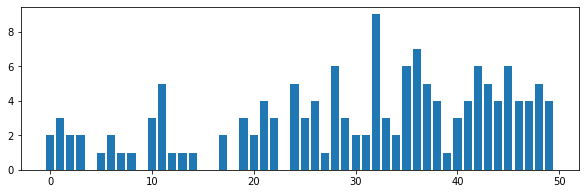

In [109]:
fig, ax = plt.subplots(figsize=(10,3))
ax.bar(np.arange(len(data)), data)

In [131]:
with pm.Model() as model:
#     alpha = 1 / data.mean()
    lambda_1 = pm.Exponential("lambda_1", .5)
    lambda_2 = pm.Exponential("lambda_2", .25)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(data))
#     tau = pm.Normal("tau", 20, 1)

    idx = np.arange(len(data))
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
    observation = pm.Poisson("obs", lambda_, observed=data)


In [132]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

INFO (theano.gof.compilelock): Refreshing lock /Users/fred.shone/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 7 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [133]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

Text(0, 0.5, 'probability')

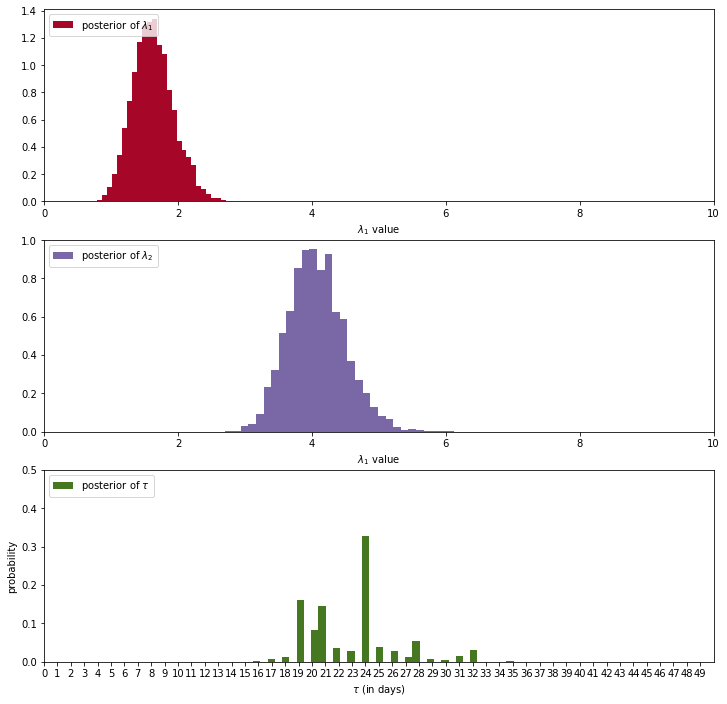

In [136]:
fig, ax = plt.subplots(3, 1, figsize=(12,12))

ax[0].hist(
    lambda_1_samples,
    histtype='stepfilled',
    bins=30,
    label="posterior of $\lambda_1$",
    color="#A60628",
    density=True
)
ax[0].legend(loc="upper left")
ax[0].set_xlim([0, 10])
ax[0].set_xlabel("$\lambda_1$ value")

ax[1].hist(
    lambda_2_samples,
    histtype='stepfilled',
    bins=30,
    label="posterior of $\lambda_2$",
    color="#7A68A6",
    density=True
)
ax[1].legend(loc="upper left")
ax[1].set_xlim([0, 10])
ax[1].set_xlabel("$\lambda_1$ value")

w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
ax[2].hist(
    tau_samples,
    bins=len(data),
    alpha=1,
    label=r"posterior of $\tau$",
    color="#467821",
    weights=w,
    rwidth=2.
)
ax[2].set_xticks(np.arange(len(data)))
ax[2].legend(loc="upper left")
ax[2].set_ylim([0, .5])
ax[2].set_xlim([0, len(data)])
ax[2].set_xlabel(r"$\tau$ (in days)")
ax[2].set_ylabel("probability")

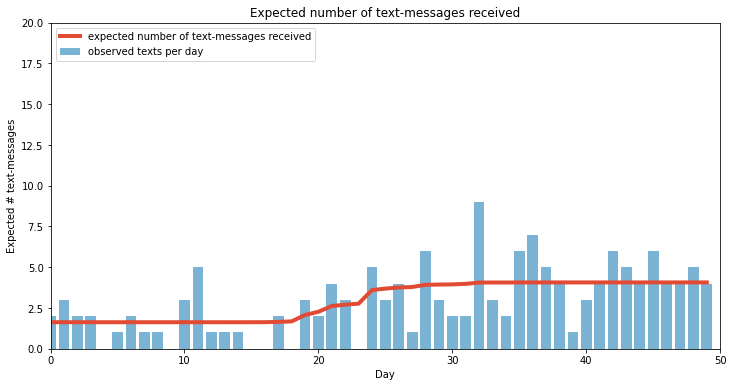

In [137]:
fig, ax = plt.subplots(figsize=(12,6))
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(len(data))

for day in range(0, len(data)):
    ix = day < tau_samples
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum()) / N

ax.plot(
    range(len(data)),
    expected_texts_per_day,
    lw=4,
    color="#E24A33",
    label="expected number of text-messages received"
)
ax.set_xlim(0, len(data))
ax.set_xlabel("Day")
ax.set_ylabel("Expected # text-messages")
ax.set_title("Expected number of text-messages received")
ax.set_ylim(0, 20)

ax.bar(
    np.arange(len(data)),
    data,
    color="#348ABD",
    alpha=0.65,
    label="observed texts per day"
)

ax.legend(loc="upper left")